In [432]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    include_hydrogen=include_hydrogen,
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 128
train_loader = DataLoader(train_dataset[:1024], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [433]:
train_batch = next(iter(train_loader))
train_batch

DataBatch(x=[1132, 4], edge_index=[2, 2384], edge_attr=[2384, 4], y=[128, 19], pos=[2337, 3], z=[2337], smiles=[128], name=[128], idx=[128], batch=[1132], ptr=[129])

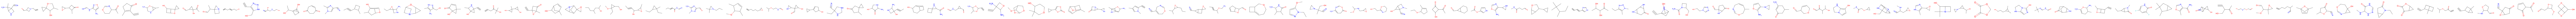

In [435]:
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
if batch_size > 1:
    axs = axs.flatten()

for i in range(len(train_batch)):
    batch_mask = train_batch.batch == i
    
    graph = train_batch[i]
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if batch_size > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")

plt.tight_layout()
plt.show()

# Decoder

In [479]:
import itertools
from typing import Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F


class MixtureModelDecoder(nn.Module):

    def __init__(self, hparams: Dict[str, Any]) -> None:
        super().__init__()

        num_clusters = hparams["num_clusters"]
        self.num_clusters = num_clusters
        latent_dim = hparams["latent_dim"]
        num_atom_types = hparams["num_atom_types"]
        num_bond_types = hparams["num_bond_types"] + 1  # +1 for non-existent bonds

        # model parameters
        self.eta_mu = nn.Parameter(torch.zeros(1, num_clusters))
        self.eta_log_sigma = nn.Parameter(torch.randn(1, num_clusters))
        self.cluster_means = nn.Parameter(torch.randn(1, num_clusters, latent_dim))
        self.cluster_log_sigmas = nn.Parameter(torch.randn(1, num_clusters, latent_dim))
        self.atom_classifier = nn.Sequential(
            nn.Linear(latent_dim, num_atom_types),
            #nn.Softmax(dim=1)  # apply softmax in the loss
        )
        self.bond_matrix = nn.Parameter(torch.randn(1, num_bond_types, latent_dim, latent_dim))

        self.gumbel_softmax_temperature = 1.0

        # create edge indices of fully connected graph for all graph sizes up to 50
        self.edge_indices = []
        for N in range(2, 50):
            self.edge_indices.append(
                torch.tensor(list(itertools.combinations(range(N), 2)))
            )

    def set_gumbel_softmax_temperature(self, temperature: float):
        self.gumbel_softmax_temperature = temperature

    def decode_eta(self, eta: torch.Tensor) -> torch.Tensor:
        return F.softmax(eta, dim=1)
    
    def decode_z(self, z: torch.Tensor, num_atoms: torch.Tensor) -> Data:
        atom_types = self.atom_classifier(z)

        device = z.device
        
        # create edge indices of fully connected graphs
        edge_index_list = []
        offsets = torch.cat([torch.tensor([0], device=device), torch.cumsum(num_atoms, dim=0)[:-1]])
        for i, N in enumerate(num_atoms):
            pairs = self.edge_indices[N - 2].to(device)
            pairs += offsets[i]
            edge_index_list.append(pairs)

        edge_index = torch.cat(edge_index_list, dim=0)

        # make bond matrix symmetric to ensure permuation invariance
        W = (self.bond_matrix + self.bond_matrix.transpose(2, 3)) * 0.5

        z_pairs = z[edge_index].unsqueeze(-2).unsqueeze(-1)
        edge_type_logits = z_pairs[:, 0].permute(dims=(0, 1, 3, 2)) @ W @ z_pairs[:, 1]
        edge_types = F.softmax(edge_type_logits, dim=1).squeeze()

        edge_index = edge_index.t().contiguous()

        batch = torch.repeat_interleave(torch.arange(len(num_atoms), device=device), num_atoms)
        return Data(x=atom_types, edge_index=edge_index, edge_attr=edge_types, batch=batch)


    def forward(self, eta: torch.Tensor, num_atoms: torch.Tensor) -> Data:

        pi = self.decode_eta(eta)
        log_pi = torch.log(pi)

        # sample clusters using the gumbel-softmax reparameterization
        c = F.gumbel_softmax(
            logits=torch.repeat_interleave(log_pi, num_atoms, dim=0),
            tau=self.gumbel_softmax_temperature,
            hard=True
        ).unsqueeze(-1)

        mu = torch.sum(self.cluster_means * c, dim=1)
        log_sigma = torch.sum(self.cluster_log_sigmas * c, dim=1)
        sigma = torch.exp(torch.clamp(log_sigma, -20, 30))

        z = torch.randn_like(mu) * sigma + mu

        return self.decode_z(z, num_atoms)


    def sample(self, num_atoms: torch.Tensor, device: str) -> Data:
        eta = torch.randn(size=(num_atoms.size(0), self.num_clusters), device=device)
        return self.forward(eta, num_atoms)

    

num_clusters = 12
hparams = {
    "num_clusters": num_clusters,
    "latent_dim": 8,
    "num_atom_types": dataset.num_node_features,
    "num_bond_types": dataset.num_edge_features,
}
print(hparams)

decoder_model = MixtureModelDecoder(hparams=hparams).to(device)

num_atoms = torch.tensor([3, 3], dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)
data

{'num_clusters': 12, 'latent_dim': 8, 'num_atom_types': 4, 'num_bond_types': 4}


Data(x=[6, 4], edge_index=[2, 6], edge_attr=[6, 5], batch=[6])

In [437]:
def get_batch_item(batch_data: Data, i: int):
    node_mask = batch_data.batch == i

    offsets = torch.cumsum(torch.bincount(batch_data.batch), dim=0)

    edge_mask = (batch_data.edge_index[0] < offsets[i]) & (batch_data.edge_index[1] < offsets[i])
    if i > 0:
        edge_mask &= (batch_data.edge_index[0] >= offsets[i - 1]) & (batch_data.edge_index[1] >= offsets[i - 1])

    # remove non-existent edges
    edge_mask &= batch_data.edge_attr.argmax(dim=1) < 4
    edge_attr = batch_data.edge_attr[edge_mask][:,:-1]

    # adjust edge index based on batch index
    edge_index = batch_data.edge_index[:, edge_mask]
    if i > 0:
        edge_index -= offsets[i - 1]

    return Data(
        x=batch_data.x[node_mask],
        edge_index=edge_index,
        edge_attr=edge_attr
    )

get_batch_item(data, 1)

Data(x=[3, 4], edge_index=[2, 3], edge_attr=[3, 4])

# Encoder

In [438]:
from torch_geometric.nn import BatchNorm
from graph_vae.encoder import ECCConv, GlobalGraphPooling


class MixtureModelEncoder(nn.Module):

    def __init__(self, hparams: Dict[str, Any]) -> None:
        super().__init__()

        self.z_latent_dim = hparams["latent_dim"]
        self.eta_latent_dim = hparams["num_clusters"]

        channels = [16, 32, 64]

        module_list = [
            ECCConv(
                num_edge_features=hparams["num_bond_types"],
                in_channels=hparams["num_atom_types"],
                out_channels=channels[0]
            ),
            BatchNorm(in_channels=channels[0]),
            nn.PReLU()
        ]
        for i in range(len(channels) - 1):
            module_list.extend([
                ECCConv(
                    num_edge_features=hparams["num_bond_types"],
                    in_channels=channels[i],
                    out_channels=channels[i + 1]
                ),
                BatchNorm(in_channels=channels[i + 1]),
                nn.PReLU()
            ])

        self.gnn_layers = nn.ModuleList(module_list)
        self.z_head = nn.Linear(channels[-1], self.z_latent_dim * 2)

        self.graph_pooling = GlobalGraphPooling(in_channels=channels[-1], out_channels=channels[-1])
        self.eta_head = nn.Linear(in_features=channels[-1], out_features=self.eta_latent_dim * 2)
        

    def forward(self, data: Data) -> Tuple[torch.Tensor, torch.Tensor]:
        x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        for layer in self.gnn_layers:
            if isinstance(layer, ECCConv):
                x = layer(x, edge_index, edge_attr)
            else:
                x = layer(x)

        z = self.z_head(x)

        z_mu = z[:, :self.z_latent_dim]
        z_log_sigma = z[:, self.z_latent_dim:]
        z_sigma = torch.exp(torch.clamp(z_log_sigma, -20, 30))

        eta = self.eta_head(self.graph_pooling(x, batch))

        eta_mu = eta[:, :self.eta_latent_dim]
        eta_log_sigma = eta[:, self.eta_latent_dim:]
        eta_sigma = torch.exp(torch.clamp(eta_log_sigma, -20, 30))

        return z_mu, z_sigma, eta_mu, eta_sigma

In [481]:
import torch.distributions as D
from torch_geometric.utils import scatter


def kl_divergence_gaussian(mu_q, sigma_q, mu_p, sigma_p):
    """
    KL(q||p)
    """
    return (torch.log(sigma_p / (sigma_q + 1e-6)) + ((sigma_q ** 2 + (mu_q - mu_p) ** 2)) / (2 * (sigma_p ** 2) + 1e-6) - 0.5).sum(dim=1)


def kl_divergence_categorical(pi_q, pi_p):
    """
    KL(q||p)
    """
    pi_q = pi_q + 1e-6
    pi_p = pi_p + 1e-6
    return (pi_q * torch.log(pi_q / pi_p)).sum(dim=1)


encoder_model = MixtureModelEncoder(hparams=hparams).to(device)
decoder_model = MixtureModelDecoder(hparams=hparams).to(device)


epochs = 1000
optimizer = torch.optim.Adam(params=list(encoder_model.parameters()) + list(decoder_model.parameters()), lr=1e-3, weight_decay=1e-5)

encoder_model.train()
decoder_model.train()

decoder_model.set_gumbel_softmax_temperature(temperature=1.0)
N = 100
r = 1e-4

loss_vals = []

for epoch in tqdm(range(epochs)):

    for batch_index, train_batch in enumerate(train_loader):

        iteration = len(train_loader) * epoch + batch_index

        if (iteration + 1) % N == 0:
            tau = max(0.5, math.exp(-r * iteration))
            decoder_model.set_gumbel_softmax_temperature(tau)
            print(f"Set tau = {tau}")

        optimizer.zero_grad()

        train_z_mu, train_z_sigma, train_eta_mu, train_eta_sigma = encoder_model(train_batch)
        train_z = torch.randn_like(train_z_mu) * train_z_sigma + train_z_mu
        train_num_atoms = torch.bincount(train_batch.batch)
        train_reconstruction = decoder_model.decode_z(train_z, train_num_atoms)
        train_target_x = torch.argmax(train_batch.x, dim=1)

        # atom reconstruction loss
        loss = F.cross_entropy(input=train_reconstruction.x, target=train_target_x, reduction="sum")
        loss /= len(train_batch)


        # TODO: bond reconstruction loss


        # eta KL-Divergence
        eta_kl_divergence = kl_divergence_gaussian(
            mu_q=train_eta_mu,
            sigma_q=train_eta_sigma,
            mu_p=decoder_model.eta_mu,
            sigma_p=torch.exp(torch.clamp(decoder_model.eta_log_sigma, -20, 30))
        ).mean()  # mean over batch
        loss += eta_kl_divergence

        # cluster KL-Divergence
        train_eta = torch.randn_like(train_eta_mu) * train_eta_sigma + train_eta_mu
        train_pi_p = decoder_model.decode_eta(train_eta)
        train_pi_p = torch.repeat_interleave(train_pi_p, train_num_atoms, dim=0)
        train_z_log_likelihoods = D.Normal(
            loc=decoder_model.cluster_means, 
            scale=torch.exp(torch.clamp(decoder_model.cluster_log_sigmas, -20, 30))
        ).log_prob(train_z.unsqueeze(1)).sum(dim=2)
        train_weighted_z_log_likelihood = train_z_log_likelihoods + torch.log(train_pi_p)
        train_z_log_responsibilities = train_weighted_z_log_likelihood - torch.logsumexp(train_weighted_z_log_likelihood, dim=1, keepdim=True)
        train_pi_q = torch.exp(train_z_log_responsibilities)
        cluster_kl_divergence = kl_divergence_categorical(
            pi_q=train_pi_q,
            pi_p=train_pi_p,
        )
        # sum over all atoms in each molecule
        cluster_kl_divergence = scatter(cluster_kl_divergence, train_batch.batch, dim=0, reduce='sum')
        # mean over batches
        cluster_kl_divergence = cluster_kl_divergence.mean()
        loss += cluster_kl_divergence

        # z KL-Divergence
        sigma_pc = torch.exp(torch.clamp(decoder_model.cluster_log_sigmas, -20, 30))
        z_kl_divergence = kl_divergence_gaussian(
            mu_q=train_z_mu.unsqueeze(-1),
            sigma_q=train_z_sigma.unsqueeze(-1),
            mu_p=decoder_model.cluster_means.transpose(1, 2),
            sigma_p=sigma_pc.transpose(1, 2)
        )
        z_kl_divergence = (z_kl_divergence * train_pi_q).sum(dim=1)
        # sum over all nodes in each molecule and average over batch
        z_kl_divergence = scatter(z_kl_divergence, train_batch.batch, dim=0, reduce='sum').mean()
        loss += z_kl_divergence

        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())


encoder_model.eval()
decoder_model.eval()

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 12/1000 [00:06<09:04,  1.81it/s]

Set tau = 0.9901488436829572


  2%|▎         | 25/1000 [00:14<09:07,  1.78it/s]

Set tau = 0.9802966980752427


  4%|▎         | 37/1000 [00:20<08:49,  1.82it/s]

Set tau = 0.9705425829542524


  5%|▌         | 50/1000 [00:27<08:38,  1.83it/s]

Set tau = 0.9608855229003458


  6%|▌         | 62/1000 [00:34<08:36,  1.82it/s]

Set tau = 0.9513245521994698


  8%|▊         | 75/1000 [00:41<08:30,  1.81it/s]

Set tau = 0.9418587147465868


  9%|▊         | 87/1000 [00:48<08:13,  1.85it/s]

Set tau = 0.9324870639500633


 10%|█         | 100/1000 [00:55<08:10,  1.83it/s]

Set tau = 0.9232086626370101


 11%|█         | 112/1000 [01:01<08:20,  1.78it/s]

Set tau = 0.9140225829595635


 12%|█▎        | 125/1000 [01:09<08:05,  1.80it/s]

Set tau = 0.9049279063021011


 14%|█▎        | 137/1000 [01:15<07:59,  1.80it/s]

Set tau = 0.8959237231893779


 15%|█▌        | 150/1000 [01:23<07:58,  1.78it/s]

Set tau = 0.8870091331955793


 16%|█▌        | 162/1000 [01:29<07:38,  1.83it/s]

Set tau = 0.8781832448542769


 18%|█▊        | 175/1000 [01:36<07:33,  1.82it/s]

Set tau = 0.8694451755692818


 19%|█▊        | 187/1000 [01:43<07:31,  1.80it/s]

Set tau = 0.8607940515263837


 20%|██        | 200/1000 [01:50<07:19,  1.82it/s]

Set tau = 0.8522290076059689


 21%|██        | 212/1000 [01:57<07:08,  1.84it/s]

Set tau = 0.843749187296508


 22%|██▎       | 225/1000 [02:04<07:12,  1.79it/s]

Set tau = 0.8353537426089034


 24%|██▎       | 237/1000 [02:11<07:33,  1.68it/s]

Set tau = 0.8270418339916902


 25%|██▌       | 250/1000 [02:18<06:43,  1.86it/s]

Set tau = 0.8188126302470798


 26%|██▌       | 262/1000 [02:24<06:42,  1.83it/s]

Set tau = 0.8106653084478405


 28%|██▊       | 275/1000 [02:32<06:45,  1.79it/s]

Set tau = 0.8025990538550025


 29%|██▊       | 287/1000 [02:38<06:26,  1.84it/s]

Set tau = 0.7946130598363847


 30%|███       | 300/1000 [02:45<06:25,  1.82it/s]

Set tau = 0.7867065277859304


 31%|███       | 312/1000 [02:52<06:23,  1.79it/s]

Set tau = 0.7788786670438457


 32%|███▎      | 325/1000 [02:59<06:04,  1.85it/s]

Set tau = 0.7711286948175331


 34%|███▎      | 337/1000 [03:06<06:00,  1.84it/s]

Set tau = 0.7634558361033116


 35%|███▌      | 350/1000 [03:13<05:58,  1.81it/s]

Set tau = 0.7558593236089157


 36%|███▌      | 362/1000 [03:19<05:53,  1.81it/s]

Set tau = 0.7483383976767656


 38%|███▊      | 375/1000 [03:27<05:56,  1.75it/s]

Set tau = 0.7408923062080006


 39%|███▊      | 387/1000 [03:33<05:48,  1.76it/s]

Set tau = 0.7335203045872687


 40%|████      | 400/1000 [03:40<05:30,  1.81it/s]

Set tau = 0.7262216556082645


 41%|████      | 412/1000 [03:47<05:20,  1.84it/s]

Set tau = 0.7189956294000078


 42%|████▎     | 425/1000 [03:54<05:17,  1.81it/s]

Set tau = 0.7118415033538562


 44%|████▎     | 437/1000 [04:01<05:15,  1.79it/s]

Set tau = 0.7047585620512432


 45%|████▌     | 450/1000 [04:08<04:58,  1.84it/s]

Set tau = 0.6977460971921361


 46%|████▌     | 462/1000 [04:15<04:53,  1.84it/s]

Set tau = 0.6908034075242052


 48%|████▊     | 475/1000 [04:22<04:56,  1.77it/s]

Set tau = 0.6839297987726981


 49%|████▊     | 487/1000 [04:29<04:41,  1.82it/s]

Set tau = 0.6771245835710117


 50%|█████     | 500/1000 [04:36<04:35,  1.81it/s]

Set tau = 0.6703870813919548


 51%|█████     | 512/1000 [04:42<04:31,  1.80it/s]

Set tau = 0.6637166184796949


 52%|█████▎    | 525/1000 [04:49<04:17,  1.85it/s]

Set tau = 0.6571125277823819


 54%|█████▎    | 537/1000 [04:56<04:14,  1.82it/s]

Set tau = 0.6505741488854427


 55%|█████▌    | 550/1000 [05:03<04:06,  1.82it/s]

Set tau = 0.6441008279455391


 56%|█████▌    | 562/1000 [05:10<03:58,  1.84it/s]

Set tau = 0.6376919176251825


 57%|█████▊    | 575/1000 [05:17<03:50,  1.84it/s]

Set tau = 0.6313467770280001


 59%|█████▊    | 587/1000 [05:24<03:53,  1.77it/s]

Set tau = 0.6250647716346446


 60%|██████    | 600/1000 [05:31<03:46,  1.77it/s]

Set tau = 0.6188452732393416


 61%|██████    | 612/1000 [05:38<03:31,  1.83it/s]

Set tau = 0.6126876598870686


 62%|██████▎   | 625/1000 [05:45<03:29,  1.79it/s]

Set tau = 0.606591315811359


 64%|██████▎   | 637/1000 [05:51<03:18,  1.82it/s]

Set tau = 0.6005556313727252


 65%|██████▌   | 650/1000 [05:59<03:08,  1.86it/s]

Set tau = 0.5945800029976932


 66%|██████▌   | 662/1000 [06:05<03:08,  1.80it/s]

Set tau = 0.588663833118446


 68%|██████▊   | 675/1000 [06:13<03:01,  1.79it/s]

Set tau = 0.5828065301130654


 69%|██████▊   | 687/1000 [06:19<02:53,  1.81it/s]

Set tau = 0.5770075082463699


 70%|███████   | 700/1000 [06:27<02:44,  1.82it/s]

Set tau = 0.5712661876113403


 71%|███████   | 712/1000 [06:33<02:36,  1.84it/s]

Set tau = 0.5655819940711284


 72%|███████▎  | 725/1000 [06:40<02:27,  1.87it/s]

Set tau = 0.5599543592016437


 74%|███████▎  | 737/1000 [06:47<02:21,  1.86it/s]

Set tau = 0.5543827202347094


 75%|███████▌  | 750/1000 [06:54<02:18,  1.81it/s]

Set tau = 0.5488665200017855


 76%|███████▌  | 762/1000 [07:00<02:09,  1.84it/s]

Set tau = 0.5434052068782521


 78%|███████▊  | 775/1000 [07:08<02:02,  1.84it/s]

Set tau = 0.5379982347282458


 79%|███████▊  | 787/1000 [07:14<01:56,  1.83it/s]

Set tau = 0.5326450628500456


 80%|████████  | 800/1000 [07:21<01:52,  1.78it/s]

Set tau = 0.5273451559220028


 81%|████████  | 812/1000 [07:28<01:44,  1.80it/s]

Set tau = 0.522097983949008


 82%|████████▎ | 825/1000 [07:35<01:34,  1.85it/s]

Set tau = 0.5169030222094912


 84%|████████▎ | 837/1000 [07:42<01:29,  1.83it/s]

Set tau = 0.5117597512029493


 85%|████████▌ | 850/1000 [07:49<01:21,  1.84it/s]

Set tau = 0.5066676565979955


 86%|████████▌ | 862/1000 [07:55<01:16,  1.81it/s]

Set tau = 0.501626229180926


 88%|████████▊ | 875/1000 [08:02<01:09,  1.80it/s]

Set tau = 0.5


 89%|████████▊ | 887/1000 [08:09<01:05,  1.73it/s]

Set tau = 0.5


 90%|█████████ | 900/1000 [08:16<00:55,  1.80it/s]

Set tau = 0.5


 91%|█████████ | 912/1000 [08:23<00:49,  1.78it/s]

Set tau = 0.5


 92%|█████████▎| 925/1000 [08:30<00:40,  1.83it/s]

Set tau = 0.5


 94%|█████████▎| 937/1000 [08:37<00:34,  1.82it/s]

Set tau = 0.5


 95%|█████████▌| 950/1000 [08:44<00:27,  1.84it/s]

Set tau = 0.5


 96%|█████████▌| 962/1000 [08:51<00:20,  1.83it/s]

Set tau = 0.5


 98%|█████████▊| 975/1000 [08:58<00:13,  1.81it/s]

Set tau = 0.5


 99%|█████████▊| 987/1000 [09:04<00:07,  1.82it/s]

Set tau = 0.5


100%|██████████| 1000/1000 [09:11<00:00,  1.81it/s]

Set tau = 0.5


MixtureModelDecoder(
  (atom_classifier): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [482]:
torch.exp(decoder_model.eta_log_sigma)

tensor([[0.3095, 0.2741, 0.2689, 0.2825, 1.4704, 0.1534, 0.3080, 0.5985, 0.2790,
         0.2270, 0.2853, 0.3239]], device='cuda:0', grad_fn=<ExpBackward0>)

In [483]:
loss_vals[-1]

7.078244209289551

In [484]:
torch.exp(decoder_model.eta_log_sigma).mean()

tensor(0.3984, device='cuda:0', grad_fn=<MeanBackward0>)

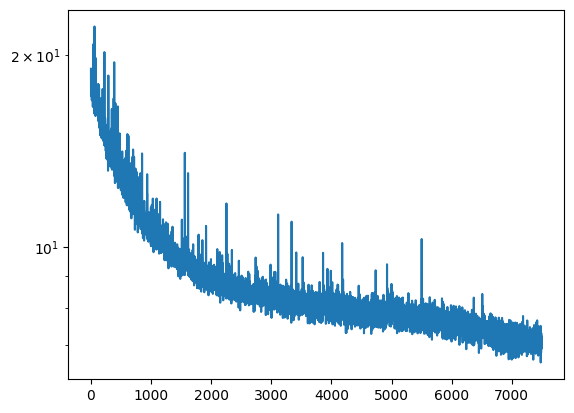

In [485]:
plt.plot(loss_vals[500:])
plt.yscale("log")
plt.show()

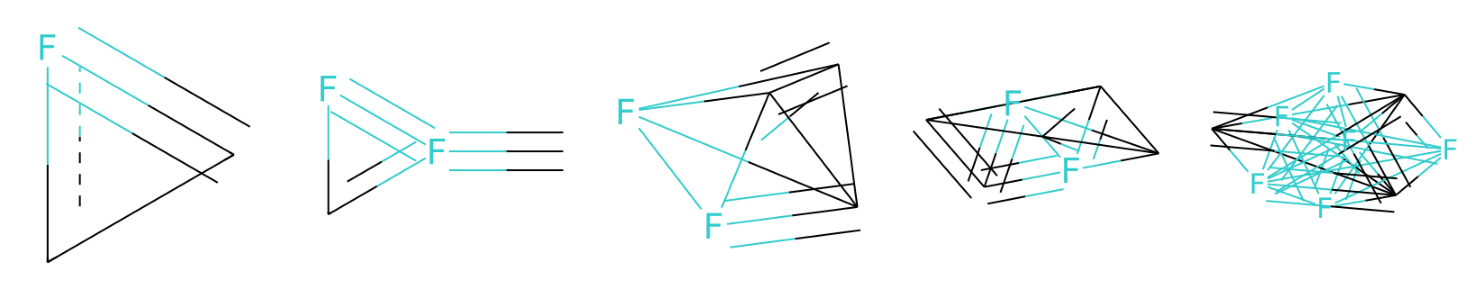

In [496]:
num_atoms = torch.tensor([3, 4, 5, 6, 9], dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)

num_molecules = len(num_atoms)

fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 3, 3))
if num_molecules > 1:
    axs = axs.flatten()

for i in range(num_molecules):
    graph = get_batch_item(data, i)
    #graph.edge_index = None
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if num_molecules > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")


plt.tight_layout()
plt.show()